## Preprocessing and Training Data Development

This section aims to make a ready to model dataset by encoding all the categorical features and drop any collinear features and scaling the data if applicable.

## Importing Basic Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

In [3]:
#Loading datasets
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone_3_final/df_cook_without_dummies.csv')
df['date']=pd.to_datetime(df['date'])
df.head()

,date,case,death,avg.temp,pop_stay_at_home,pop_not_stay_at_home,air_traffic,public_holiday,gatherings,ratio_pop_not_stay_and_stay,ratio_pop_stay_and_not_stay,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_stay_home_order,days_since_BLM_Protest,days_since_travel_ban_china,days_since_travel_ban_Brazil,days_since_travel_ban_Europe,days_since_Easter,days_since_Memorial Day,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Day_of_week
0,2020-01-24,1.0,0.0,31.5,1096712.0,4083781.0,3545834.0,No,No,3.723659,0.268553,no,no,no,no,no,no,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,24,Friday
1,2020-01-25,0.0,0.0,34.5,1212883.0,3967610.0,3545834.0,No,No,3.271222,0.305696,no,no,no,no,no,no,1,0,0,0,0,0,0,0,0,0,0,0,2020,1,25,Saturday
2,2020-01-26,0.0,0.0,31.0,1300363.0,3880130.0,3545834.0,No,No,2.983882,0.335134,no,no,no,no,no,no,2,0,0,0,0,0,0,0,0,0,0,0,2020,1,26,Sunday
3,2020-01-27,0.0,0.0,29.5,1126001.0,4054492.0,3545834.0,No,No,3.600789,0.277717,no,no,no,no,no,no,3,0,0,0,0,0,0,0,0,0,0,0,2020,1,27,Monday
4,2020-01-28,0.0,0.0,31.5,1117075.0,4063418.0,3545834.0,No,No,3.637552,0.274910,no,no,no,no,no,no,4,0,0,0,0,0,0,0,0,0,0,0,2020,1,28,Tuesday


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          388 non-null    datetime64[ns]
 1   case                          374 non-null    float64       
 2   death                         374 non-null    float64       
 3   avg.temp                      374 non-null    float64       
 4   pop_stay_at_home              374 non-null    float64       
 5   pop_not_stay_at_home          374 non-null    float64       
 6   air_traffic                   374 non-null    float64       
 7   public_holiday                388 non-null    object        
 8   gatherings                    388 non-null    object        
 9   ratio_pop_not_stay_and_stay   374 non-null    float64       
 10  ratio_pop_stay_and_not_stay   374 non-null    float64       
 11  holiday_surge_cases           38

**There are no null entries (null entries in some of the features are due to the forecast section of the dataset) and all the datatypes are correct.**

#### Collinear Features

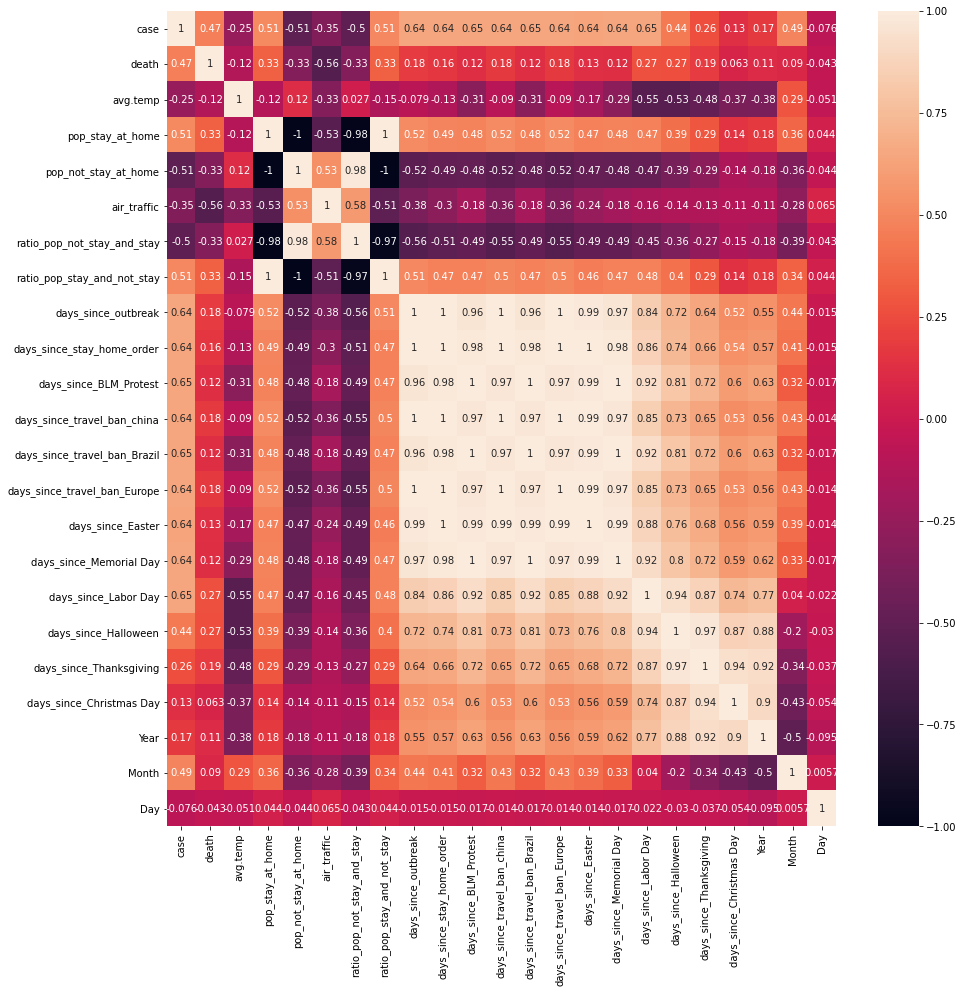

In [ ]:
#Visualization of correlation between numeric features
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True)

In [5]:
#Remove collinear features
# correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.98
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]

df=df.drop(df[to_drop], axis=1)
df.head()

,date,case,death,avg.temp,pop_stay_at_home,air_traffic,public_holiday,gatherings,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Day_of_week
0,2020-01-24,1.0,0.0,31.5,1096712.0,3545834.0,No,No,no,no,no,no,no,no,0,0,0,0,0,0,2020,1,24,Friday
1,2020-01-25,0.0,0.0,34.5,1212883.0,3545834.0,No,No,no,no,no,no,no,no,1,0,0,0,0,0,2020,1,25,Saturday
2,2020-01-26,0.0,0.0,31.0,1300363.0,3545834.0,No,No,no,no,no,no,no,no,2,0,0,0,0,0,2020,1,26,Sunday
3,2020-01-27,0.0,0.0,29.5,1126001.0,3545834.0,No,No,no,no,no,no,no,no,3,0,0,0,0,0,2020,1,27,Monday
4,2020-01-28,0.0,0.0,31.5,1117075.0,3545834.0,No,No,no,no,no,no,no,no,4,0,0,0,0,0,2020,1,28,Tuesday


In [6]:
len(to_drop)

9

### Transforming Categorical Features

In [7]:
cat=list(df.select_dtypes('object').columns)
cat

['public_holiday',
 'gatherings',
 'holiday_surge_cases',
 'stay_home_order',
 'BLM_Protest',
 'travel_ban_china',
 'travel_ban_Europe',
 'travel_ban_Brazil',
 'Day_of_week']

In [8]:
df[cat].nunique()

public_holiday         11
gatherings              7
holiday_surge_cases     2
stay_home_order         2
BLM_Protest             2
travel_ban_china        2
travel_ban_Europe       2
travel_ban_Brazil       2
Day_of_week             7
dtype: int64

In [9]:
#Label encoding for boolen features
feat=['holiday_surge_cases', 'stay_home_order', 'BLM_Protest', 'travel_ban_china', 'travel_ban_Europe', 'travel_ban_Brazil']
for i in feat:
  df[i]= label_encoder.fit_transform(df[i])
df.head()

,date,case,death,avg.temp,pop_stay_at_home,air_traffic,public_holiday,gatherings,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Day_of_week
0,2020-01-24,1.0,0.0,31.5,1096712.0,3545834.0,No,No,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,24,Friday
1,2020-01-25,0.0,0.0,34.5,1212883.0,3545834.0,No,No,0,0,0,0,0,0,1,0,0,0,0,0,2020,1,25,Saturday
2,2020-01-26,0.0,0.0,31.0,1300363.0,3545834.0,No,No,0,0,0,0,0,0,2,0,0,0,0,0,2020,1,26,Sunday
3,2020-01-27,0.0,0.0,29.5,1126001.0,3545834.0,No,No,0,0,0,0,0,0,3,0,0,0,0,0,2020,1,27,Monday
4,2020-01-28,0.0,0.0,31.5,1117075.0,3545834.0,No,No,0,0,0,0,0,0,4,0,0,0,0,0,2020,1,28,Tuesday


In [10]:
#Dummies for non-boolean categorical features
dummies=pd.get_dummies(df['Day_of_week'],drop_first=True)
df=pd.concat([df,dummies], axis=1)
df.drop('Day_of_week', inplace=True, axis=1)
df

,date,case,death,avg.temp,pop_stay_at_home,air_traffic,public_holiday,gatherings,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2020-01-24,1.0,0.0,31.5,1096712.0,3545834.0,No,No,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,24,0,0,0,0,0,0
1,2020-01-25,0.0,0.0,34.5,1212883.0,3545834.0,No,No,0,0,0,0,0,0,1,0,0,0,0,0,2020,1,25,0,1,0,0,0,0
2,2020-01-26,0.0,0.0,31.0,1300363.0,3545834.0,No,No,0,0,0,0,0,0,2,0,0,0,0,0,2020,1,26,0,0,1,0,0,0
3,2020-01-27,0.0,0.0,29.5,1126001.0,3545834.0,No,No,0,0,0,0,0,0,3,0,0,0,0,0,2020,1,27,1,0,0,0,0,0
4,2020-01-28,0.0,0.0,31.5,1117075.0,3545834.0,No,No,0,0,0,0,0,0,4,0,0,0,0,0,2020,1,28,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,2021-02-10,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,383,257,156,102,76,47,2021,2,10,0,0,0,0,0,1
384,2021-02-11,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,384,258,157,103,77,48,2021,2,11,0,0,0,1,0,0
385,2021-02-12,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,385,259,158,104,78,49,2021,2,12,0,0,0,0,0,0
386,2021-02-13,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,386,260,159,105,79,50,2021,2,13,0,1,0,0,0,0


In [11]:
df1=df[df['date']>'2021-01-31']
df2=df[df['date']<='2021-01-31']

In [12]:
df1

,date,case,death,avg.temp,pop_stay_at_home,air_traffic,public_holiday,gatherings,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
374,2021-02-01,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,374,248,147,93,67,38,2021,2,1,1,0,0,0,0,0
375,2021-02-02,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,375,249,148,94,68,39,2021,2,2,0,0,0,0,1,0
376,2021-02-03,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,376,250,149,95,69,40,2021,2,3,0,0,0,0,0,1
377,2021-02-04,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,377,251,150,96,70,41,2021,2,4,0,0,0,1,0,0
378,2021-02-05,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,378,252,151,97,71,42,2021,2,5,0,0,0,0,0,0
379,2021-02-06,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,379,253,152,98,72,43,2021,2,6,0,1,0,0,0,0
380,2021-02-07,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,380,254,153,99,73,44,2021,2,7,0,0,1,0,0,0
381,2021-02-08,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,381,255,154,100,74,45,2021,2,8,1,0,0,0,0,0
382,2021-02-09,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,382,256,155,101,75,46,2021,2,9,0,0,0,0,1,0
383,2021-02-10,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,383,257,156,102,76,47,2021,2,10,0,0,0,0,0,1


In [13]:
#Moving average to smooth the data
df2['case']=df2['case'].rolling(3, min_periods=1).mean()
df2['death']=df2['death'].rolling(3, min_periods=1).mean()


In [14]:
df=pd.concat([df2,df1])
df.tail(20)

,date,case,death,avg.temp,pop_stay_at_home,air_traffic,public_holiday,gatherings,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
368,2021-01-26,1231.666667,17.666667,31.0,1679133.0,1.044186e+06,No,No,0,0,0,1,1,1,368,242,141,87,61,32,2021,1,26,0,0,0,0,1,0
369,2021-01-27,1206.333333,20.666667,26.5,1531688.0,1.044186e+06,No,No,0,0,0,1,1,1,369,243,142,88,62,33,2021,1,27,0,0,0,0,0,1
370,2021-01-28,1360.333333,31.666667,19.0,1504432.0,1.044186e+06,No,No,0,0,0,1,1,1,370,244,143,89,63,34,2021,1,28,0,0,0,1,0,0
371,2021-01-29,1428.666667,31.333333,18.0,1441925.0,1.044186e+06,No,No,0,0,0,1,1,1,371,245,144,90,64,35,2021,1,29,0,0,0,0,0,0
372,2021-01-30,1398.666667,23.000000,23.5,1467123.0,1.044186e+06,No,No,0,0,0,1,1,1,372,246,145,91,65,36,2021,1,30,0,1,0,0,0,0
373,2021-01-31,1172.666667,3.666667,29.5,1845331.0,1.044186e+06,No,No,0,0,0,1,1,1,373,247,146,92,66,37,2021,1,31,0,0,1,0,0,0
374,2021-02-01,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,374,248,147,93,67,38,2021,2,1,1,0,0,0,0,0
375,2021-02-02,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,375,249,148,94,68,39,2021,2,2,0,0,0,0,1,0
376,2021-02-03,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,376,250,149,95,69,40,2021,2,3,0,0,0,0,0,1
377,2021-02-04,NaN,NaN,NaN,NaN,NaN,No,No,0,0,0,1,1,1,377,251,150,96,70,41,2021,2,4,0,0,0,1,0,0


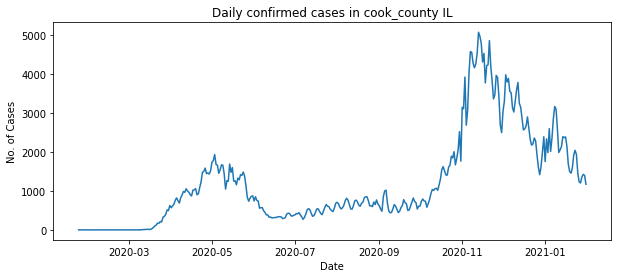

In [15]:
#visualization
_=plt.figure(figsize=(10,4))
_=sns.lineplot(x='date',y='case', data=df,)
_=plt.ylabel('No. of Cases')
_=plt.xlabel('Date')
_=plt.title('Daily confirmed cases in cook_county IL')

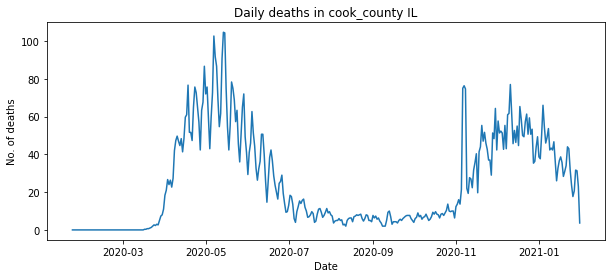

In [16]:
#visualization
_=plt.figure(figsize=(10,4))
_=sns.lineplot(x='date',y='death', data=df,)
_=plt.ylabel('No. of deaths')
_=plt.xlabel('Date')
_=plt.title('Daily deaths in cook_county IL')

**Still some unusual peak on Nov., let's explore it.**

In [17]:
abc=df[(df['date']>'2020-10-15') & (df['date']<'2020-11-30')][['date','death']]
abc

,date,death
266,2020-10-16,8.333333
267,2020-10-17,9.666667
268,2020-10-18,8.333333
269,2020-10-19,8.000000
270,2020-10-20,6.333333
271,2020-10-21,8.333333
272,2020-10-22,8.666667
273,2020-10-23,7.666667
274,2020-10-24,9.000000
275,2020-10-25,10.333333


In [18]:
abc['avg.death']=abc['death'].rolling(10).mean()
abc[(df['date']>='2020-11-06') & (df['date']<='2020-11-08')][['date','death','avg.death']]

,date,death,avg.death
287,2020-11-06,75.000000,18.800000
288,2020-11-07,76.333333,25.466667
289,2020-11-08,74.666667,31.933333


In [19]:
df1=df[df['date']<'2020-11-06']
df2=df[(df['date']>='2020-11-06') & (df['date']<='2020-11-08')]
df3=df[df['date']>'2020-11-08']
df2['death']=[18.800000,25.466667,31.933333]
df=df1.append(df2).append(df3)
df[(df['date']>='2020-11-06') & (df['date']<='2020-11-08')]

,date,case,death,avg.temp,pop_stay_at_home,air_traffic,public_holiday,gatherings,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
287,2020-11-06,4027.333333,18.800000,59.0,1442803.0,1.164003e+06,No,No,0,0,0,1,1,1,287,161,60,6,0,0,2020,11,6,0,0,0,0,0,0
288,2020-11-07,4582.666667,25.466667,60.5,1492917.0,1.164003e+06,No,No,1,0,0,1,1,1,288,162,61,7,0,0,2020,11,7,0,1,0,0,0,0
289,2020-11-08,4561.666667,31.933333,60.0,1689945.0,1.164003e+06,No,No,1,0,0,1,1,1,289,163,62,8,0,0,2020,11,8,0,0,1,0,0,0


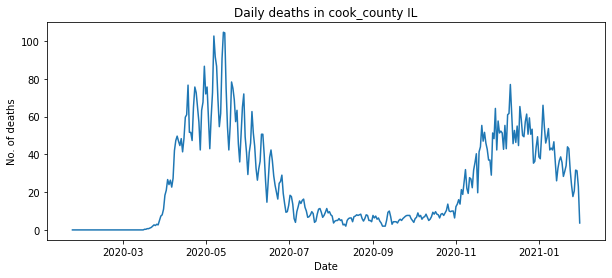

In [20]:
#visualization
_=plt.figure(figsize=(10,4))
_=sns.lineplot(x='date',y='death', data=df,)
_=plt.ylabel('No. of deaths')
_=plt.xlabel('Date')
_=plt.title('Daily deaths in cook_county IL')

**Adding features lagged by 14 to the dataset.**

In [21]:
features_for_lag=['case', 'death', 'avg.temp', 'pop_stay_at_home',
       'air_traffic',
       'days_since_outbreak',
       'days_since_BLM_Protest',
       'days_since_Labor Day',
       'days_since_Halloween', 'days_since_Thanksgiving',
       'days_since_Christmas Day', 'Day', 'holiday_surge_cases', 'stay_home_order','BLM_Protest',
       'travel_ban_china', 'travel_ban_Europe',
       'travel_ban_Brazil']

In [22]:
for feature in features_for_lag:
  lagged_feature_name='lag_14_'+str(feature)
  lagged_feature=[]
  for i in range(len(df)):
    if i<=13:
      lagged_feature.append(np.nan)
    else:
      lagged_feature.append(df[feature][i-14])
  df[lagged_feature_name]=lagged_feature

df.head()

,date,case,death,avg.temp,pop_stay_at_home,air_traffic,public_holiday,gatherings,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,lag_14_case,lag_14_death,lag_14_avg.temp,lag_14_pop_stay_at_home,lag_14_air_traffic,lag_14_days_since_outbreak,lag_14_days_since_BLM_Protest,lag_14_days_since_Labor Day,lag_14_days_since_Halloween,lag_14_days_since_Thanksgiving,lag_14_days_since_Christmas Day,lag_14_Day,lag_14_holiday_surge_cases,lag_14_stay_home_order,lag_14_BLM_Protest,lag_14_travel_ban_china,lag_14_travel_ban_Europe,lag_14_travel_ban_Brazil
0,2020-01-24,1.000000,0.0,31.5,1096712.0,3545834.0,No,No,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,24,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-25,0.500000,0.0,34.5,1212883.0,3545834.0,No,No,0,0,0,0,0,0,1,0,0,0,0,0,2020,1,25,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-26,0.333333,0.0,31.0,1300363.0,3545834.0,No,No,0,0,0,0,0,0,2,0,0,0,0,0,2020,1,26,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-27,0.000000,0.0,29.5,1126001.0,3545834.0,No,No,0,0,0,0,0,0,3,0,0,0,0,0,2020,1,27,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-28,0.000000,0.0,31.5,1117075.0,3545834.0,No,No,0,0,0,0,0,0,4,0,0,0,0,0,2020,1,28,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 387
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             388 non-null    datetime64[ns]
 1   case                             374 non-null    float64       
 2   death                            374 non-null    float64       
 3   avg.temp                         374 non-null    float64       
 4   pop_stay_at_home                 374 non-null    float64       
 5   air_traffic                      374 non-null    float64       
 6   public_holiday                   388 non-null    object        
 7   gatherings                       388 non-null    object        
 8   holiday_surge_cases              388 non-null    int64         
 9   stay_home_order                  388 non-null    int64         
 10  BLM_Protest                      388 non-null    int64        

In [24]:
#Save Dataset
df.to_csv('/content/drive/MyDrive/Colab Notebooks/capstone_3_final/df_cook_including_lag.csv', index=False)

In [ ]:
#Loading Dataset
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone_3_final/df_cook_including_lag.csv')
df.head()

,date,case,death,avg.temp,pop_stay_at_home,air_traffic,public_holiday,gatherings,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,lag_14_case,lag_14_death,lag_14_avg.temp,lag_14_pop_stay_at_home,lag_14_air_traffic,lag_14_days_since_outbreak,lag_14_days_since_BLM_Protest,lag_14_days_since_Labor Day,lag_14_days_since_Halloween,lag_14_days_since_Thanksgiving,lag_14_days_since_Christmas Day,lag_14_Day,lag_14_holiday_surge_cases,lag_14_stay_home_order,lag_14_BLM_Protest,lag_14_travel_ban_china,lag_14_travel_ban_Europe,lag_14_travel_ban_Brazil
0,2020-01-24,1.000000,0.0,31.5,1096712.0,3545834.0,No,No,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,24,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-25,0.500000,0.0,34.5,1212883.0,3545834.0,No,No,0,0,0,0,0,0,1,0,0,0,0,0,2020,1,25,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-26,0.333333,0.0,31.0,1300363.0,3545834.0,No,No,0,0,0,0,0,0,2,0,0,0,0,0,2020,1,26,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-27,0.000000,0.0,29.5,1126001.0,3545834.0,No,No,0,0,0,0,0,0,3,0,0,0,0,0,2020,1,27,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-28,0.000000,0.0,31.5,1117075.0,3545834.0,No,No,0,0,0,0,0,0,4,0,0,0,0,0,2020,1,28,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   date                             388 non-null    object 
 1   case                             376 non-null    float64
 2   death                            376 non-null    float64
 3   avg.temp                         374 non-null    float64
 4   pop_stay_at_home                 374 non-null    float64
 5   air_traffic                      374 non-null    float64
 6   public_holiday                   388 non-null    object 
 7   gatherings                       388 non-null    object 
 8   holiday_surge_cases              388 non-null    int64  
 9   stay_home_order                  388 non-null    int64  
 10  BLM_Protest                      388 non-null    int64  
 11  travel_ban_china                 388 non-null    int64  
 12  travel_ban_Europe     

## Averaged_Cases

In [ ]:
df_case=df.drop(['public_holiday','gatherings','death','lag_14_death'], axis=1)
df_case.head()

,date,case,avg.temp,pop_stay_at_home,air_traffic,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,lag_14_case,lag_14_avg.temp,lag_14_pop_stay_at_home,lag_14_air_traffic,lag_14_days_since_outbreak,lag_14_days_since_BLM_Protest,lag_14_days_since_Labor Day,lag_14_days_since_Halloween,lag_14_days_since_Thanksgiving,lag_14_days_since_Christmas Day,lag_14_Day,lag_14_holiday_surge_cases,lag_14_stay_home_order,lag_14_BLM_Protest,lag_14_travel_ban_china,lag_14_travel_ban_Europe,lag_14_travel_ban_Brazil
0,2020-01-24,1.000000,31.5,1096712.0,3545834.0,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,24,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-25,0.500000,34.5,1212883.0,3545834.0,0,0,0,0,0,0,1,0,0,0,0,0,2020,1,25,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-26,0.333333,31.0,1300363.0,3545834.0,0,0,0,0,0,0,2,0,0,0,0,0,2020,1,26,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-27,0.000000,29.5,1126001.0,3545834.0,0,0,0,0,0,0,3,0,0,0,0,0,2020,1,27,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-28,0.000000,31.5,1117075.0,3545834.0,0,0,0,0,0,0,4,0,0,0,0,0,2020,1,28,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   date                             388 non-null    object 
 1   case                             376 non-null    float64
 2   avg.temp                         374 non-null    float64
 3   pop_stay_at_home                 374 non-null    float64
 4   air_traffic                      374 non-null    float64
 5   holiday_surge_cases              388 non-null    int64  
 6   stay_home_order                  388 non-null    int64  
 7   BLM_Protest                      388 non-null    int64  
 8   travel_ban_china                 388 non-null    int64  
 9   travel_ban_Europe                388 non-null    int64  
 10  travel_ban_Brazil                388 non-null    int64  
 11  days_since_outbreak              388 non-null    int64  
 12  days_since_BLM_Protest

In [ ]:
df1=df_case[df_case['date']>'2021-01-31']
df2=df_case[df_case['date']<='2021-01-31']
df1['case']=df1['case'].replace({1026.5:np.nan,892.0:np.nan})
df_case=pd.concat([df2,df1])
df_case

,date,case,avg.temp,pop_stay_at_home,air_traffic,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,lag_14_case,lag_14_avg.temp,lag_14_pop_stay_at_home,lag_14_air_traffic,lag_14_days_since_outbreak,lag_14_days_since_BLM_Protest,lag_14_days_since_Labor Day,lag_14_days_since_Halloween,lag_14_days_since_Thanksgiving,lag_14_days_since_Christmas Day,lag_14_Day,lag_14_holiday_surge_cases,lag_14_stay_home_order,lag_14_BLM_Protest,lag_14_travel_ban_china,lag_14_travel_ban_Europe,lag_14_travel_ban_Brazil
0,2020-01-24,1.000000,31.5,1096712.0,3545834.0,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,24,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-25,0.500000,34.5,1212883.0,3545834.0,0,0,0,0,0,0,1,0,0,0,0,0,2020,1,25,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-26,0.333333,31.0,1300363.0,3545834.0,0,0,0,0,0,0,2,0,0,0,0,0,2020,1,26,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-27,0.000000,29.5,1126001.0,3545834.0,0,0,0,0,0,0,3,0,0,0,0,0,2020,1,27,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-28,0.000000,31.5,1117075.0,3545834.0,0,0,0,0,0,0,4,0,0,0,0,0,2020,1,28,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,2021-02-10,NaN,NaN,NaN,NaN,0,0,0,1,1,1,383,257,156,102,76,47,2021,2,10,0,0,0,0,0,1,1206.333333,26.5,1531688.0,1.044186e+06,369.0,243.0,142.0,88.0,62.0,33.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0
384,2021-02-11,NaN,NaN,NaN,NaN,0,0,0,1,1,1,384,258,157,103,77,48,2021,2,11,0,0,0,1,0,0,1360.333333,19.0,1504432.0,1.044186e+06,370.0,244.0,143.0,89.0,63.0,34.0,28.0,0.0,0.0,0.0,1.0,1.0,1.0
385,2021-02-12,NaN,NaN,NaN,NaN,0,0,0,1,1,1,385,259,158,104,78,49,2021,2,12,0,0,0,0,0,0,1428.666667,18.0,1441925.0,1.044186e+06,371.0,245.0,144.0,90.0,64.0,35.0,29.0,0.0,0.0,0.0,1.0,1.0,1.0
386,2021-02-13,NaN,NaN,NaN,NaN,0,0,0,1,1,1,386,260,159,105,79,50,2021,2,13,0,1,0,0,0,0,1398.666667,23.5,1467123.0,1.044186e+06,372.0,246.0,145.0,91.0,65.0,36.0,30.0,0.0,0.0,0.0,1.0,1.0,1.0


In [ ]:
df_case.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 387
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   date                             388 non-null    object 
 1   case                             374 non-null    float64
 2   avg.temp                         374 non-null    float64
 3   pop_stay_at_home                 374 non-null    float64
 4   air_traffic                      374 non-null    float64
 5   holiday_surge_cases              388 non-null    int64  
 6   stay_home_order                  388 non-null    int64  
 7   BLM_Protest                      388 non-null    int64  
 8   travel_ban_china                 388 non-null    int64  
 9   travel_ban_Europe                388 non-null    int64  
 10  travel_ban_Brazil                388 non-null    int64  
 11  days_since_outbreak              388 non-null    int64  
 12  days_since_BLM_Protest

#### Seasonality Check

<Figure size 432x288 with 0 Axes>

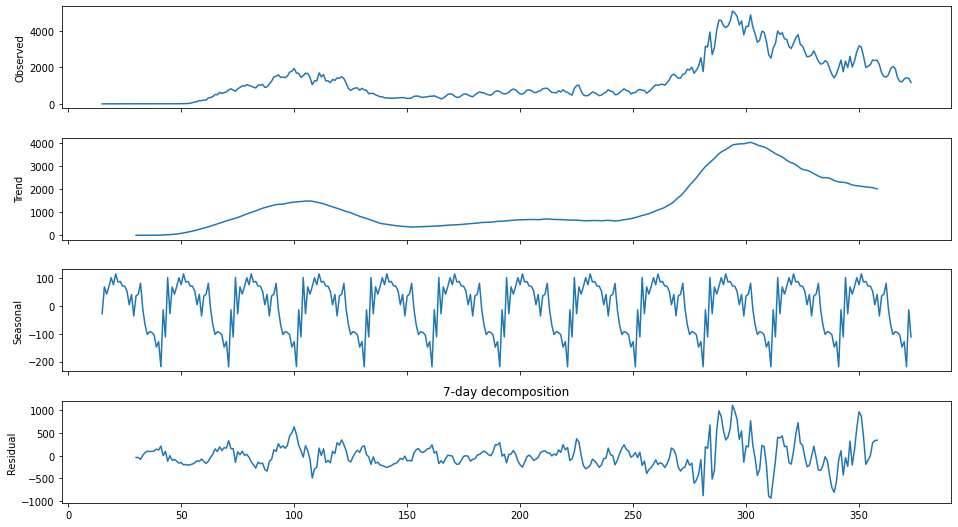

In [ ]:
decomposition = seasonal_decompose(df_case.dropna()['case'], freq=30)  
fig = plt.figure()  
fig = decomposition.plot()
plt.title('7-day decomposition')  
fig.set_size_inches(15, 8)

In [ ]:
df=df_case[(df_case['date']>='2020-03-01') & (df_case['date']<'2020-04-01')]
df.dropna(inplace=True)
df.head()

,date,case,avg.temp,pop_stay_at_home,pop_not_stay_at_home,ratio_pop_not_stay_and_stay,ratio_pop_stay_and_not_stay,air_traffic,days_since_outbreak,days_since_stay_home_order,days_since_BLM_Protest,days_since_travel_ban_china,days_since_travel_ban_Brazil,days_since_travel_ban_Europe,days_since_Easter,days_since_Memorial Day,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,holiday_surge_cases_yes,stay_home_order_yes,BLM_Protest_yes,travel_ban_china_yes,travel_ban_Europe_yes,travel_ban_Brazil_yes,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,lag_14_case,lag_14_avg.temp,lag_14_pop_stay_at_home,lag_14_pop_not_stay_at_home,lag_14_ratio_pop_not_stay_and_stay,lag_14_ratio_pop_stay_and_not_stay,lag_14_air_traffic,lag_14_days_since_outbreak,lag_14_days_since_stay_home_order,lag_14_days_since_BLM_Protest,lag_14_days_since_travel_ban_china,lag_14_days_since_travel_ban_Brazil,lag_14_days_since_travel_ban_Europe,lag_14_days_since_Easter,lag_14_days_since_Memorial Day,lag_14_days_since_Labor Day,lag_14_days_since_Halloween,lag_14_days_since_Thanksgiving,lag_14_days_since_Christmas Day,lag_14_Day,lag_14_holiday_surge_cases_yes,lag_14_stay_home_order_yes,lag_14_BLM_Protest_yes,lag_14_travel_ban_china_yes,lag_14_travel_ban_Europe_yes,lag_14_travel_ban_Brazil_yes
37,2020-03-01,0.333333,23.5,1204481.0,3976012.0,3.301017,0.302937,2054836.0,37,0,0,10,0,10,0,0,0,0,0,0,2020,3,1,0,0,0,1,1,0,0,0,1,0,0,0,0.0,3.5,1212830.0,3967663.0,3.271409,0.305679,3304198.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
38,2020-03-02,0.666667,41.5,1116787.0,4063706.0,3.638748,0.274820,2054836.0,38,0,0,11,0,11,0,0,0,0,0,0,2020,3,2,0,0,0,1,1,0,1,0,0,0,0,0,0.0,22.0,1313889.0,3866604.0,2.942870,0.339804,3304198.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0
39,2020-03-03,0.333333,41.0,1030607.0,4149886.0,4.026643,0.248346,2054836.0,39,0,0,12,0,12,0,0,0,0,0,0,2020,3,3,0,0,0,1,1,0,0,0,0,0,1,0,0.0,28.0,1550369.0,3630124.0,2.341458,0.427084,3304198.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0
40,2020-03-04,0.333333,40.5,1042590.0,4137903.0,3.968869,0.251961,2054836.0,40,0,0,13,0,13,0,0,0,0,0,0,2020,3,4,0,0,0,1,1,0,0,0,0,0,0,1,0.0,34.0,1134668.0,4045825.0,3.565647,0.280454,3304198.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
41,2020-03-05,0.333333,39.0,969106.0,4211387.0,4.345641,0.230116,2054836.0,41,0,0,14,0,14,0,0,0,0,0,0,2020,3,5,0,0,0,1,1,0,0,0,0,1,0,0,0.0,28.0,1075087.0,4105406.0,3.818673,0.261871,3304198.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 432x288 with 0 Axes>

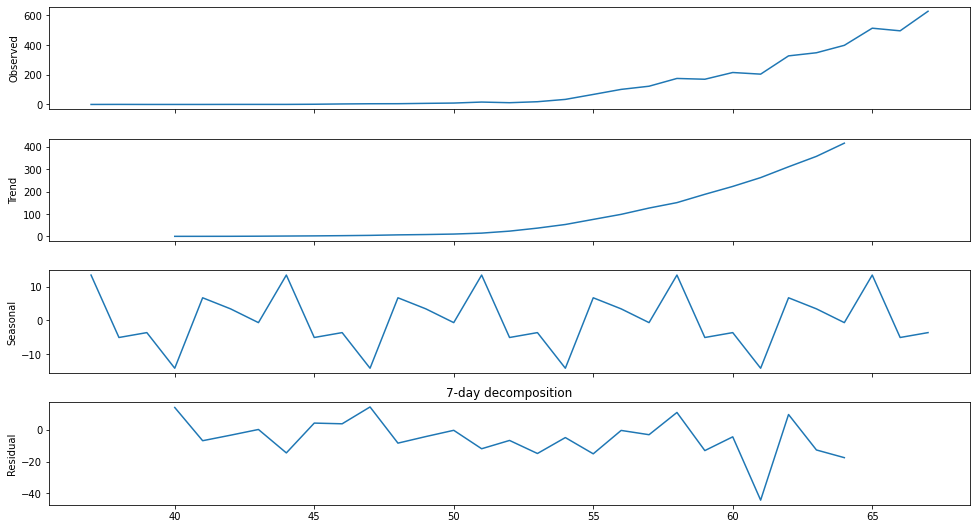

In [ ]:
decomposition = seasonal_decompose(df['case'], freq=7)  
fig = plt.figure()  
fig = decomposition.plot()
plt.title('7-day decomposition')  
fig.set_size_inches(15, 8)

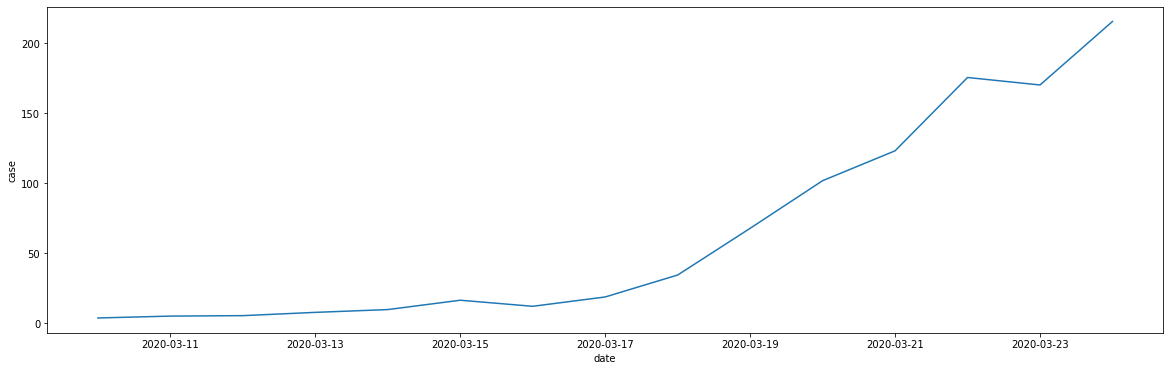

In [ ]:
df1=df_case[(df_case['date']>='2020-03-10') & (df_case['date']<'2020-03-25')]


df1['date']=pd.to_datetime(df1['date'])

plt.figure(figsize=(20,6))
sns.lineplot(x='date', y='case', data=df1)

<Figure size 432x288 with 0 Axes>

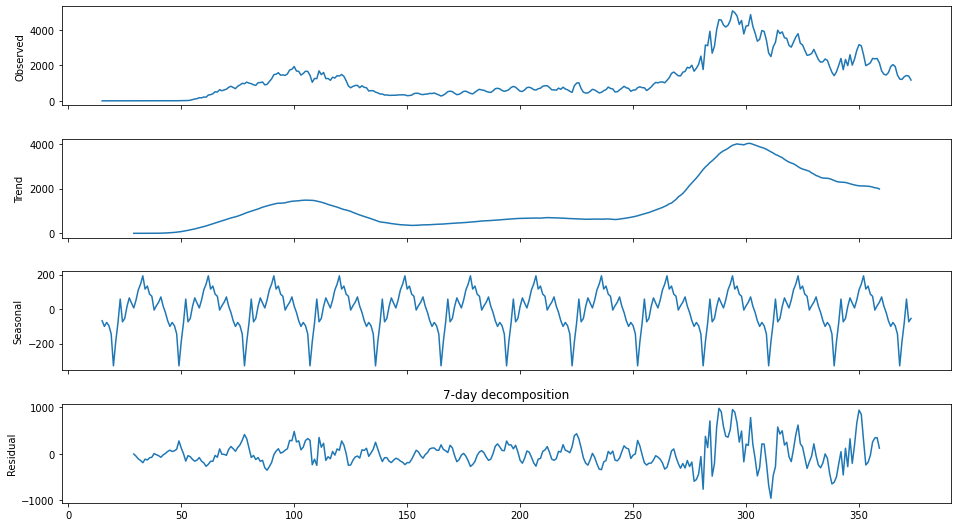

In [ ]:
decomposition = seasonal_decompose(df_case.dropna()['case'], freq=29)  
fig = plt.figure()  
fig = decomposition.plot()
plt.title('7-day decomposition')  
fig.set_size_inches(15, 8)

**There is no significant seasonality**

### Train test split and scaling

**Since some of the features: 'avg.temp', pop_stay_at_home', 'air_traffic' are not available for forecast data, we should drop those feature for training and testing.**

In [ ]:
df_case=df_case.drop(['avg.temp','pop_stay_at_home', 'air_traffic'],axis=1)
df_case.head()

,date,case,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,lag_14_case,lag_14_avg.temp,lag_14_pop_stay_at_home,lag_14_air_traffic,lag_14_days_since_outbreak,lag_14_days_since_BLM_Protest,lag_14_days_since_Labor Day,lag_14_days_since_Halloween,lag_14_days_since_Thanksgiving,lag_14_days_since_Christmas Day,lag_14_Day,lag_14_holiday_surge_cases,lag_14_stay_home_order,lag_14_BLM_Protest,lag_14_travel_ban_china,lag_14_travel_ban_Europe,lag_14_travel_ban_Brazil
0,2020-01-24,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,24,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-25,0.500000,0,0,0,0,0,0,1,0,0,0,0,0,2020,1,25,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-26,0.333333,0,0,0,0,0,0,2,0,0,0,0,0,2020,1,26,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-27,0.000000,0,0,0,0,0,0,3,0,0,0,0,0,2020,1,27,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-28,0.000000,0,0,0,0,0,0,4,0,0,0,0,0,2020,1,28,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Train, test and forecast split
train=df_case[df_case['date']<'2020-11-01'].set_index('date')
test=df_case[(df_case['date']>='2020-11-01') & (df_case['date']<='2021-01-31') ].set_index('date')
forecast=df_case[df_case['date']>='2021-02-01'].set_index('date')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(train)
scaled_test=scaler.transform(test)

## Averaged_Deaths

In [ ]:
df_death=df.drop(['public_holiday','gatherings','case','lag_14_case'], axis=1)
df_case.head()

,date,case,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,lag_14_case,lag_14_avg.temp,lag_14_pop_stay_at_home,lag_14_air_traffic,lag_14_days_since_outbreak,lag_14_days_since_BLM_Protest,lag_14_days_since_Labor Day,lag_14_days_since_Halloween,lag_14_days_since_Thanksgiving,lag_14_days_since_Christmas Day,lag_14_Day,lag_14_holiday_surge_cases,lag_14_stay_home_order,lag_14_BLM_Protest,lag_14_travel_ban_china,lag_14_travel_ban_Europe,lag_14_travel_ban_Brazil
0,2020-01-24,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,24,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-25,0.500000,0,0,0,0,0,0,1,0,0,0,0,0,2020,1,25,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-26,0.333333,0,0,0,0,0,0,2,0,0,0,0,0,2020,1,26,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-27,0.000000,0,0,0,0,0,0,3,0,0,0,0,0,2020,1,27,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-28,0.000000,0,0,0,0,0,0,4,0,0,0,0,0,2020,1,28,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df1=df_death[df_death['date']>'2021-01-31']
df2=df_death[df_death['date']<='2021-01-31']

In [ ]:
df1['death']

374    0.0
375    0.0
376    NaN
377    NaN
378    NaN
379    NaN
380    NaN
381    NaN
382    NaN
383    NaN
384    NaN
385    NaN
386    NaN
387    NaN
Name: death, dtype: float64

In [ ]:
df1['death']=df1['death'].replace({0.0:np.nan})
df1

,date,death,avg.temp,pop_stay_at_home,air_traffic,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,lag_14_death,lag_14_avg.temp,lag_14_pop_stay_at_home,lag_14_air_traffic,lag_14_days_since_outbreak,lag_14_days_since_BLM_Protest,lag_14_days_since_Labor Day,lag_14_days_since_Halloween,lag_14_days_since_Thanksgiving,lag_14_days_since_Christmas Day,lag_14_Day,lag_14_holiday_surge_cases,lag_14_stay_home_order,lag_14_BLM_Protest,lag_14_travel_ban_china,lag_14_travel_ban_Europe,lag_14_travel_ban_Brazil
374,2021-02-01,NaN,NaN,NaN,NaN,0,0,0,1,1,1,374,248,147,93,67,38,2021,2,1,1,0,0,0,0,0,35.666667,26.5,1392541.0,1.044186e+06,360.0,234.0,133.0,79.0,53.0,24.0,18.0,0.0,0.0,0.0,1.0,1.0,1.0
375,2021-02-02,NaN,NaN,NaN,NaN,0,0,0,1,1,1,375,249,148,94,68,39,2021,2,2,0,0,0,0,1,0,28.333333,22.0,1673302.0,1.044186e+06,361.0,235.0,134.0,80.0,54.0,25.0,19.0,0.0,0.0,0.0,1.0,1.0,1.0
376,2021-02-03,NaN,NaN,NaN,NaN,0,0,0,1,1,1,376,250,149,95,69,40,2021,2,3,0,0,0,0,0,1,31.000000,23.5,1624453.0,1.044186e+06,362.0,236.0,135.0,81.0,55.0,26.0,20.0,0.0,0.0,0.0,1.0,1.0,1.0
377,2021-02-04,NaN,NaN,NaN,NaN,0,0,0,1,1,1,377,251,150,96,70,41,2021,2,4,0,0,0,1,0,0,34.000000,23.0,1477028.0,1.044186e+06,363.0,237.0,136.0,82.0,56.0,27.0,21.0,0.0,0.0,0.0,1.0,1.0,1.0
378,2021-02-05,NaN,NaN,NaN,NaN,0,0,0,1,1,1,378,252,151,97,71,42,2021,2,5,0,0,0,0,0,0,44.000000,30.5,1449427.0,1.044186e+06,364.0,238.0,137.0,83.0,57.0,28.0,22.0,0.0,0.0,0.0,1.0,1.0,1.0
379,2021-02-06,NaN,NaN,NaN,NaN,0,0,0,1,1,1,379,253,152,98,72,43,2021,2,6,0,1,0,0,0,0,43.000000,15.5,1434916.0,1.044186e+06,365.0,239.0,138.0,84.0,58.0,29.0,23.0,0.0,0.0,0.0,1.0,1.0,1.0
380,2021-02-07,NaN,NaN,NaN,NaN,0,0,0,1,1,1,380,254,153,99,73,44,2021,2,7,0,0,1,0,0,0,31.666667,19.0,1592507.0,1.044186e+06,366.0,240.0,139.0,85.0,59.0,30.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0
381,2021-02-08,NaN,NaN,NaN,NaN,0,0,0,1,1,1,381,255,154,100,74,45,2021,2,8,1,0,0,0,0,0,23.666667,29.0,1544259.0,1.044186e+06,367.0,241.0,140.0,86.0,60.0,31.0,25.0,0.0,0.0,0.0,1.0,1.0,1.0
382,2021-02-09,NaN,NaN,NaN,NaN,0,0,0,1,1,1,382,256,155,101,75,46,2021,2,9,0,0,0,0,1,0,17.666667,31.0,1679133.0,1.044186e+06,368.0,242.0,141.0,87.0,61.0,32.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0
383,2021-02-10,NaN,NaN,NaN,NaN,0,0,0,1,1,1,383,257,156,102,76,47,2021,2,10,0,0,0,0,0,1,20.666667,26.5,1531688.0,1.044186e+06,369.0,243.0,142.0,88.0,62.0,33.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0


In [ ]:
df_death=pd.concat([df2,df1])
df_death

,date,death,avg.temp,pop_stay_at_home,air_traffic,holiday_surge_cases,stay_home_order,BLM_Protest,travel_ban_china,travel_ban_Europe,travel_ban_Brazil,days_since_outbreak,days_since_BLM_Protest,days_since_Labor Day,days_since_Halloween,days_since_Thanksgiving,days_since_Christmas Day,Year,Month,Day,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,lag_14_death,lag_14_avg.temp,lag_14_pop_stay_at_home,lag_14_air_traffic,lag_14_days_since_outbreak,lag_14_days_since_BLM_Protest,lag_14_days_since_Labor Day,lag_14_days_since_Halloween,lag_14_days_since_Thanksgiving,lag_14_days_since_Christmas Day,lag_14_Day,lag_14_holiday_surge_cases,lag_14_stay_home_order,lag_14_BLM_Protest,lag_14_travel_ban_china,lag_14_travel_ban_Europe,lag_14_travel_ban_Brazil
0,2020-01-24,0.0,31.5,1096712.0,3545834.0,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,24,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-25,0.0,34.5,1212883.0,3545834.0,0,0,0,0,0,0,1,0,0,0,0,0,2020,1,25,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-26,0.0,31.0,1300363.0,3545834.0,0,0,0,0,0,0,2,0,0,0,0,0,2020,1,26,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-27,0.0,29.5,1126001.0,3545834.0,0,0,0,0,0,0,3,0,0,0,0,0,2020,1,27,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-28,0.0,31.5,1117075.0,3545834.0,0,0,0,0,0,0,4,0,0,0,0,0,2020,1,28,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,2021-02-10,NaN,NaN,NaN,NaN,0,0,0,1,1,1,383,257,156,102,76,47,2021,2,10,0,0,0,0,0,1,20.666667,26.5,1531688.0,1.044186e+06,369.0,243.0,142.0,88.0,62.0,33.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0
384,2021-02-11,NaN,NaN,NaN,NaN,0,0,0,1,1,1,384,258,157,103,77,48,2021,2,11,0,0,0,1,0,0,31.666667,19.0,1504432.0,1.044186e+06,370.0,244.0,143.0,89.0,63.0,34.0,28.0,0.0,0.0,0.0,1.0,1.0,1.0
385,2021-02-12,NaN,NaN,NaN,NaN,0,0,0,1,1,1,385,259,158,104,78,49,2021,2,12,0,0,0,0,0,0,31.333333,18.0,1441925.0,1.044186e+06,371.0,245.0,144.0,90.0,64.0,35.0,29.0,0.0,0.0,0.0,1.0,1.0,1.0
386,2021-02-13,NaN,NaN,NaN,NaN,0,0,0,1,1,1,386,260,159,105,79,50,2021,2,13,0,1,0,0,0,0,23.000000,23.5,1467123.0,1.044186e+06,372.0,246.0,145.0,91.0,65.0,36.0,30.0,0.0,0.0,0.0,1.0,1.0,1.0
